In [35]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels
from sklearn.model_selection import train_test_split

from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import torch.optim as optim
from torchtext.data import Field
from torchtext.data import Dataset, TabularDataset
from torchtext.data import Iterator

from annoy import AnnoyIndex

from MulticoreTSNE import MulticoreTSNE as TSNE

%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder, LSTMEmbedder, get_fields

# Load data

In [5]:
LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'

In [6]:
labels_df = pd.read_csv(LABELS_PATH)

In [7]:
labels_df.shape

(46665, 3)

In [8]:
labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [9]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46665 entries, 0 to 46664
Data columns (total 3 columns):
left_spec_id     46665 non-null object
right_spec_id    46665 non-null object
label            46665 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


# Load specs df

In [10]:
specs_df = pd.read_csv('../data/processed/specs_preprocessed.csv')
# specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 5)

In [11]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,page_title_stem,brand,site


In [12]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com
1,www.ebay.com//60583,canon rebel 2000 35 mm great condition case,canon rebel 2000 35 mm great condit case,canon,www.ebay.com
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm,canon eo rebel t3i 18 55mm,canon,www.ebay.com
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2,ge c1033 10 1 mp 3x zoom 2,ge,www.ebay.com
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp,vivitar,www.ebay.com


# Classes df

In [13]:
classes_df = pd.read_csv('../data/interim/classes.csv')
# classes_df.index = classes_df.spec_id
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


## Add classes to specs

In [14]:
specs_df = specs_df.merge(classes_df, how='left')
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com,NaN
1,www.ebay.com//60583,canon rebel 2000 35 mm great condition case,canon rebel 2000 35 mm great condit case,canon,www.ebay.com,NaN
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm,canon eo rebel t3i 18 55mm,canon,www.ebay.com,NaN
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2,ge c1033 10 1 mp 3x zoom 2,ge,www.ebay.com,NaN
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp,vivitar,www.ebay.com,NaN


In [15]:
specs_df[specs_df.class_ == 0]

,spec_id,page_title,page_title_stem,brand,site,class_
1476,www.ebay.com//59612,excellent nikon d4 body 16 2 mp fx free,excel nikon d4 bodi 16 2 mp fx free,nikon,www.ebay.com,0.0
10648,www.ebay.com//58588,nikon d4 16 2 mp body,nikon d4 16 2 mp bodi,nikon,www.ebay.com,0.0
12740,www.ebay.com//54217,near mint nikon d4 body 16 2 mp fx,near mint nikon d4 bodi 16 2 mp fx,nikon,www.ebay.com,0.0
14506,www.price-hunt.com//9794,nikon d4 best india 2014,nikon d4 best india 2014,nikon,www.price-hunt.com,0.0
18853,buy.net//5641,nikon d4 body,nikon d4 bodi,nikon,buy.net,0.0
28521,www.gosale.com//849,nikon d4 cmos fx sale,nikon d4 cmos fx sale,nikon,www.gosale.com,0.0


In [16]:
labelled_specs_df = specs_df[~specs_df.class_.isnull()]

In [17]:
labelled_specs_df.to_csv('../data/interim/specs_df_labelled.csv', index=None)

# Triplet generator

In [18]:
labelled_specs_df['spec_idx'] = range(len(labelled_specs_df))
labelled_specs_df.head()

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
46,www.ebay.com//41954,canon eos 20d 8 2 mp,canon eo 20d 8 2 mp,canon,www.ebay.com,6.0,0
120,www.ebay.com//48059,canon 20d 8 2 mp 28 80mm,canon 20d 8 2 mp 28 80mm,canon,www.ebay.com,6.0,1
146,www.ebay.com//47121,nikon d3200 24 2 mp kit,nikon d3200 24 2 mp kit,nikon,www.ebay.com,1.0,2
245,www.ebay.com//45559,nikon 1 j3 w vr 10 30mm,nikon 1 j3 w vr 10 30mm,nikon,www.ebay.com,7.0,3
256,www.ebay.com//58782,nikon d80 10 2 mp kit,nikon d80 10 2 mp kit,nikon,www.ebay.com,15.0,4


In [19]:
# spec_lookup = labelled_specs_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()
# spec_lookup[0]

In [20]:
# class_lookup = labelled_specs_df[~labelled_specs_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
# class_lookup[143]

In [21]:
# def gen_triplet(anchor_id,
#                class_lookup_table,
#                id_lookup_table
#                ):
#     anchor_class = class_lookup_table[anchor_id]
#     positive_id = random.choice(list(set(id_lookup_table[anchor_class]).difference(set([anchor_id]))))
    
#     negative_class = random.choice(list(set(id_lookup_table.keys()).difference([anchor_class])))
#     negative_id = random.choice(id_lookup_table[negative_class])
#     return (anchor_id, positive_id, negative_id)

In [22]:
# labelled_specs_df.iloc[list(gen_triplet(0, class_lookup, spec_lookup))]

# Obtain train/val split

In [517]:
INTERIM_PATH = '../data/interim/'
TRAIN_PATH = 'specs_train.csv'
VAL_PATH = 'specs_val.csv'

classes = labelled_specs_df.class_.unique()
val_classes = np.random.choice(classes, 5)

labelled_specs_train = labelled_specs_df[~labelled_specs_df.class_.isin(val_classes)]
labelled_specs_val = labelled_specs_df[labelled_specs_df.class_.isin(val_classes)]


# labelled_specs_train, labelled_specs_val = train_test_split(labelled_specs_df, test_size=0.1)
# print(labelled_specs_train.shape, labelled_specs_val.shape)

labelled_specs_train.to_csv(os.path.join(INTERIM_PATH, TRAIN_PATH), index=None)
labelled_specs_val.to_csv(os.path.join(INTERIM_PATH, VAL_PATH), index=None)

labelled_specs_train.shape, labelled_specs_val.shape

((242, 7), (64, 7))

In [518]:
text_field = get_fields()

In [519]:
%%time
datafields = [("spec_id", None),
              ("page_title", None),
                 ("page_title_stem", text_field),
                  ("brand", None),
                  ("site", None),
             ('class_', None)]

full_dataset = TabularDataset.splits(
        path="../data/processed/", # the root directory where the data lies
        train='specs_preprocessed.csv',
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=datafields)

train_dataset, val_dataset = TabularDataset.splits(
    path=INTERIM_PATH, # the root directory where the data lies
    train=TRAIN_PATH,
    test=VAL_PATH,
    format='csv',
    skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
    fields=datafields)

full_dataset = full_dataset[0]

CPU times: user 467 ms, sys: 803 µs, total: 467 ms
Wall time: 480 ms


In [520]:
train_labelled_df = pd.read_csv(os.path.join(INTERIM_PATH, TRAIN_PATH))
train_labelled_df['spec_idx'] = range(len(train_labelled_df))

train_class_lookup = train_labelled_df[~train_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
train_spec_lookup = train_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [521]:
val_labelled_df = pd.read_csv(os.path.join(INTERIM_PATH, VAL_PATH))
val_labelled_df['spec_idx'] = range(len(val_labelled_df))

val_class_lookup = val_labelled_df[~val_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
val_spec_lookup = val_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [522]:
%%time
text_field.build_vocab(full_dataset)

CPU times: user 148 ms, sys: 5.11 ms, total: 153 ms
Wall time: 155 ms


## Quick checks

In [523]:
specs_df.head(1)

,spec_id,page_title,page_title_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com,NaN


In [524]:
full_dataset.examples[0].__dict__

{'page_title_stem': ['canon',
  'powershot',
  'elph',
  '110',
  'hs',
  '16',
  '1',
  'mp']}

In [525]:
train_labelled_df.head(1)

,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
0,www.ebay.com//41954,canon eos 20d 8 2 mp,canon eo 20d 8 2 mp,canon,www.ebay.com,6.0,0


In [526]:
train_dataset.examples[0].__dict__

{'page_title_stem': ['canon', 'eo', '20d', '8', '2', 'mp']}

In [527]:
val_labelled_df.head(1)

,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
0,www.ebay.com//45559,nikon 1 j3 w vr 10 30mm,nikon 1 j3 w vr 10 30mm,nikon,www.ebay.com,7.0,0


In [528]:
val_dataset.examples[0].__dict__

{'page_title_stem': ['nikon', '1', 'j3', 'w', 'vr', '10', '30mm']}

# Triplet iterator

In [529]:
def gen_triplet(anchor_id, class_lookup, id_lookup):

    anchor_class = class_lookup[anchor_id]
    positive_id = random.choice(list(set(id_lookup[anchor_class]).difference(set([anchor_id]))))

    negative_class = random.choice(list(set(id_lookup.keys()).difference([anchor_class])))
    negative_id = random.choice(id_lookup[negative_class])

    return (anchor_id, positive_id, negative_id)

def triplet_iterator(dataset,
                     class_lookup, 
                     spec_lookup,
                     batch_size=1):
    shuffled_idx = np.arange(len(dataset))
    np.random.shuffle(shuffled_idx)
    
    num_drop = len(shuffled_idx) % batch_size
    shuffled_idx = shuffled_idx[:-num_drop] if num_drop != 0 else shuffled_idx
    shuffled_idx = shuffled_idx.reshape(-1, batch_size)
    for idxs in shuffled_idx:
        list_triplets = []
        for i in idxs:
            _, pos_idx, neg_idx = gen_triplet(i, class_lookup, spec_lookup)
            list_triplets.extend([dataset[i].page_title_stem, 
                                  dataset[pos_idx].page_title_stem,
                                  dataset[neg_idx].page_title_stem])
        #паддим все к одному размеру
        triplet = text_field.pad(list_triplets)
        triplet = text_field.numericalize(triplet)
        yield triplet

In [530]:
(train_dataset[gen_triplet(0, train_class_lookup, train_spec_lookup)[0]].__dict__, 
train_dataset[gen_triplet(0, train_class_lookup, train_spec_lookup)[1]].__dict__,
train_dataset[gen_triplet(0, train_class_lookup, train_spec_lookup)[2]].__dict__)

({'page_title_stem': ['canon', 'eo', '20d', '8', '2', 'mp']},
 {'page_title_stem': ['cammarkt', 'canon', 'eo', '20d']},
 {'page_title_stem': ['canon', 'powershot', 'sx600', 'hs', 'camera', 'photo']})

In [531]:
(val_dataset[gen_triplet(0, val_class_lookup, val_spec_lookup)[0]].__dict__, 
val_dataset[gen_triplet(0, val_class_lookup, val_spec_lookup)[1]].__dict__,
val_dataset[gen_triplet(0, val_class_lookup, val_spec_lookup)[2]].__dict__)

({'page_title_stem': ['nikon', '1', 'j3', 'w', 'vr', '10', '30mm']},
 {'page_title_stem': ['nikon', '1', 'j3', 'kit', 'price', 'shop']},
 {'page_title_stem': ['fujifilm', 'x', 'seri', 'x10', '12', '0', 'mp']})

In [532]:
next(iter(triplet_iterator(train_dataset, train_class_lookup, train_spec_lookup, 1)))

tensor([[  4,   4,   3],
        [377, 377,   9],
        [ 29,  29, 416],
        [ 11,  11,  47],
        [  2,   2, 290],
        [ 18,  23, 363],
        [  1,   1, 889],
        [  1,   1,  33]])

In [533]:
next(iter(triplet_iterator(val_dataset, val_class_lookup, val_spec_lookup, 1)))

tensor([[   4,    4,    4],
        [ 285,  285,   14],
        [ 294,    1,  645],
        [  15,    1,  164],
        [   2,    1, 7331],
        [  18,    1,    1]])

## Initialize NN Model

In [608]:
emb_dim = 200
hidden_dim = 200
num_linear = 1
num_lstm = 1
model = LSTMEmbedder(text_field,
                     hidden_dim, emb_dim=emb_dim, num_linear=num_linear, num_lstm=num_lstm)

model

/home/boris/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTMEmbedder(
  (embedding): Embedding(7601, 200)
  (encoder): LSTM(200, 200, dropout=0.1)
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
    )
  )
)

In [609]:
model.infer(['canon eos 20d 8 2 mp'])

tensor([[ 1.2731e-01, -7.0387e-02,  4.2755e-02, -1.9639e-01, -1.8740e-01,
         -4.8583e-02,  3.6357e-02,  1.1840e-01,  1.1369e-01, -2.5840e-01,
         -1.1864e-01,  1.6462e-02, -4.4504e-02,  2.5792e-02,  1.3534e-02,
         -1.9762e-01,  1.3030e-02,  3.8552e-02,  1.2300e-01, -1.4969e-01,
          2.7027e-01, -9.3885e-02,  1.3009e-01, -6.0882e-02,  2.6268e-02,
          1.7283e-01, -2.2872e-02,  2.2433e-03,  1.3778e-01,  6.3842e-02,
         -4.5708e-02,  1.5211e-01,  8.7347e-02, -1.9828e-01, -7.4581e-02,
         -3.6471e-02, -8.4945e-02,  1.4094e-01, -6.3080e-02,  4.3299e-02,
          1.1011e-01,  1.1176e-01,  1.3641e-01,  5.5339e-02, -8.5188e-02,
          1.5122e-01, -7.1782e-02,  6.3046e-02,  5.4624e-03,  4.6658e-02,
          2.1132e-01, -7.2026e-02,  2.7161e-02,  7.7036e-02,  7.3578e-02,
          1.3796e-01, -7.3216e-02, -2.8027e-02, -1.0937e-02, -1.1465e-01,
          1.1041e-03, -1.5415e-02,  2.1099e-01,  7.7649e-02,  1.2668e-03,
          9.5120e-02, -1.9279e-04, -2.

In [610]:
loss_history_train = []
loss_history_val = []

In [611]:
opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=5, verbose=True)
batch_size= 10
epochs = 40

In [612]:
def triplet_loss(anchor, pos, neg, margin=0.8):
    """
    Consine similarity for between anchor and positive should be >= 0.8
    
    Cosine similarity for negative should be < 0.8
    """
    pos_dist = F.cosine_similarity(anchor, pos, dim=1)
    neg_dist = F.cosine_similarity(anchor, neg, dim=1)
    
    loss_pos = torch.clamp(margin-pos_dist, min=0)
    loss_neg = torch.clamp(neg_dist-margin, min=0)
    return torch.sum(loss_pos + loss_neg)

def triplet_loss(anchor, pos, neg, margin=0.5):
    """
        Triplet loss dot product
    """
    
    pos_dist = torch.norm(anchor-pos, 2, dim=1) 
    neg_dist = torch.norm(anchor-neg, 2, dim=1) 
    
    return torch.sum(torch.clamp(pos_dist-neg_dist+margin, min=0))

In [613]:
for triplet in iter(triplet_iterator(train_dataset, train_class_lookup, train_spec_lookup, batch_size=batch_size)):
    embeddings = model(triplet)
    anchors = embeddings[0::3]
    pos = embeddings[1::3]
    ng = embeddings[2::3]
    loss = triplet_loss(anchors, pos, ng)
    break
print(loss)

tensor(3.9582, grad_fn=<SumBackward0>)


# Train

In [625]:
%%time
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    
    running_loss = 0
    count_triplets = 0
    
    for triplet in iter(triplet_iterator(train_dataset, train_class_lookup, train_spec_lookup, batch_size=batch_size)):
        opt.zero_grad()
        
        embeddings = model(triplet)
        anchors = embeddings[0::3]
        pos = embeddings[1::3]
        ng = embeddings[2::3]
        loss = triplet_loss(anchors, pos, ng)
        loss.backward()
        opt.step()
        
        running_loss += loss.data
        count_triplets +=1 

    
    epoch_loss = running_loss / count_triplets
    loss_history_train.append(epoch_loss)
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, epoch_loss))
    
    model.eval()
    val_loss = 0
    count_val = 0
    with torch.no_grad():
        for triplet in iter(triplet_iterator(val_dataset, val_class_lookup, val_spec_lookup, batch_size=2)):
            embeddings = model(triplet)
            anchors = embeddings[0::3]
            pos = embeddings[1::3]
            ng = embeddings[2::3]
            loss = triplet_loss(anchors, pos, ng)
            val_loss += loss.data
            count_val +=1 
        
        epoch_val_loss = val_loss/count_val
        loss_history_val.append(epoch_val_loss)
        print('val Loss: {:.4f}'.format(epoch_val_loss))
        
    scheduler.step(epoch_val_loss)
    
model.eval()

HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

Epoch: 1, Training Loss: 0.0706
val Loss: 0.6412
Epoch: 2, Training Loss: 0.1988
val Loss: 0.6231
Epoch: 3, Training Loss: 0.0610
val Loss: 0.5515
Epoch    42: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 4, Training Loss: 0.0903
val Loss: 0.6422
Epoch: 5, Training Loss: 0.0951
val Loss: 0.5870
Epoch: 6, Training Loss: 0.1103
val Loss: 0.6366
Epoch: 7, Training Loss: 0.0583
val Loss: 0.6707
Epoch: 8, Training Loss: 0.0419
val Loss: 0.6363
Epoch: 9, Training Loss: 0.0947
val Loss: 0.7121
Epoch    48: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 10, Training Loss: 0.0624
val Loss: 0.5711
Epoch: 11, Training Loss: 0.1205
val Loss: 0.5452
Epoch: 12, Training Loss: 0.1046
val Loss: 0.7421
Epoch: 13, Training Loss: 0.1518
val Loss: 0.5509
Epoch: 14, Training Loss: 0.1828
val Loss: 0.7628
Epoch: 15, Training Loss: 0.0946
val Loss: 0.6042
Epoch: 16, Training Loss: 0.1094
val Loss: 0.7024
Epoch: 17, Training Loss: 0.1133
val Loss: 0.6890
Epoch: 18, Training Loss: 0.0408
va

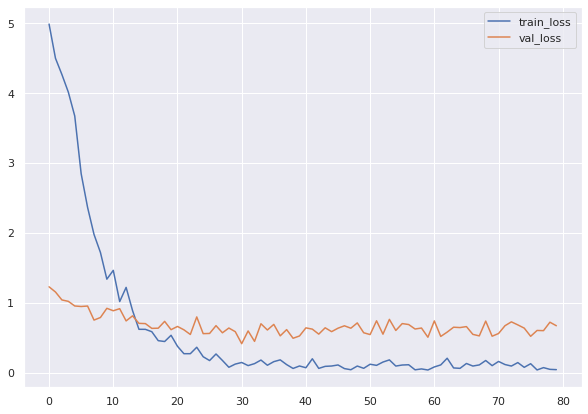

In [626]:
plt.figure()
plt.plot(loss_history_train, label='train_loss')
plt.plot(loss_history_val, label='val_loss')
plt.legend()
plt.show()

In [627]:
model.eval()

LSTMEmbedder(
  (embedding): Embedding(7601, 200)
  (encoder): LSTM(200, 200, dropout=0.1)
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
    )
  )
)

# Produce train embeddings and TSNE

In [628]:
embeddings = []
for ex in tqdm(train_dataset):
    emb = np.array(model(model.text_field.numericalize([ex.page_title_stem]))[0].data)
    embeddings.append(emb)
embeddings = np.array(embeddings)

HBox(children=(IntProgress(value=0, max=242), HTML(value='')))

In [629]:
tsne = TSNE(
    n_components=2,
    metric='cosine',
    n_jobs=3,
    verbose=True,
)

In [630]:
emb_ld = tsne.fit_transform(embeddings)

In [631]:
emb_ld.shape

(242, 2)

In [632]:
labelled_spec_classes = labelled_specs_train.class_
labelled_spec_classes = labelled_spec_classes.reset_index()
labelled_spec_classes.shape

(242, 2)

In [633]:
labelled_spec_classes.head()

,index,class_
0,46,6.0
1,120,6.0
2,146,1.0
3,256,15.0
4,336,2.0


In [634]:
emb_tdf = pd.DataFrame(emb_ld)
emb_tdf = pd.concat([emb_tdf, labelled_spec_classes], axis=1, ignore_index=True)
emb_tdf.columns = ['x', 'y', 'original_index', 'class_']
emb_tdf.head()

,x,y,original_index,class_
0,19.673364,-1.713071,46,6.0
1,21.620312,-1.234255,120,6.0
2,7.605253,-0.786488,146,1.0
3,14.022644,4.726929,256,15.0
4,0.708698,0.148982,336,2.0


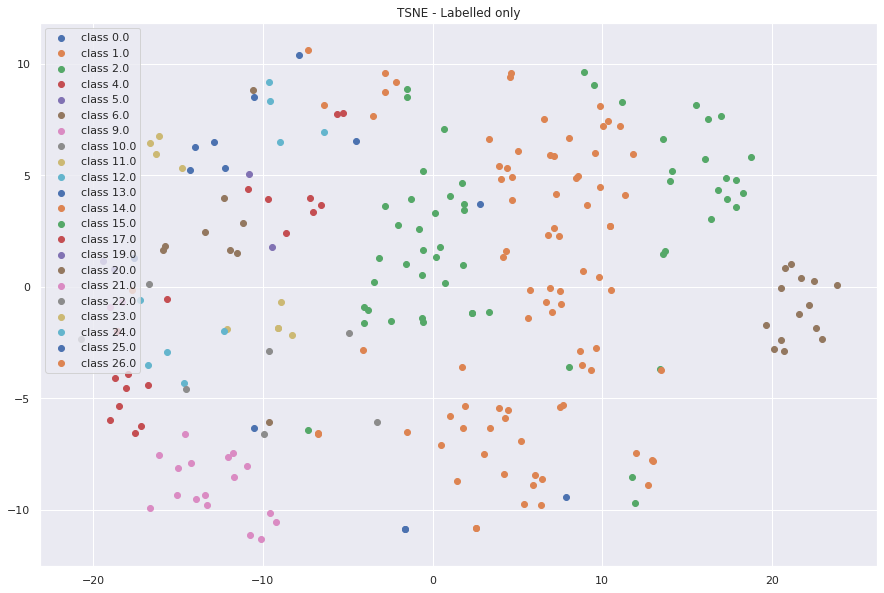

In [635]:
plt.figure(figsize=(15, 10))
plt.title('TSNE - Labelled only')
for class_ in emb_tdf['class_'].sort_values().unique():
    class_ld_df = emb_tdf[emb_tdf.class_==class_]
    plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

plt.legend()
plt.show()

# Produce whole dataset embeddings

In [636]:
embeddings = []
for ex in tqdm(full_dataset):
    emb = np.array(model(model.text_field.numericalize([ex.page_title_stem]))[0].data)
    embeddings.append(emb)
embeddings = np.array(embeddings)

HBox(children=(IntProgress(value=0, max=29771), HTML(value='')))

In [637]:
emb = Embedder(model, specs_df.spec_id.values, specs_df.page_title_stem.values)

In [ ]:
emb.fit(embeddings)

In [ ]:
emb.lookup_texts('canon eo 20d')

In [66]:
emb.save('../models/embedder')